In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
import ast
import matplotlib.pyplot as plt
import os

In [2]:
class Args:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.max_len = 100        # N
        self.hidden_units = 128   # d
        self.num_heads = 4       # h
        self.num_layers = 2       # L
        self.dropout_rate = 0.1
        self.mask_prob = 0.2      # rho
        self.batch_size = 128
        self.lr = 1e-5
        self.epochs = 100
        self.mask_token = self.vocab_size + 1

In [3]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def extract_user_sequence_from_parquet(user_history):
    all_movies = [movie for seq in user_history['list_movies'] for movie in seq]

    unique_movies = sorted(list(set(all_movies)))
    movie_to_id = {movie: i + 1 for i, movie in enumerate(unique_movies)}

    user_sequences = user_history['list_movies'].apply(
        lambda seq: [movie_to_id[m] for m in seq]
    ).tolist()

    vocab_size = len(unique_movies)
    print(f"   -> Found {len(user_sequences)} sequences.")
    print(f"   -> Vocab Size is {vocab_size}")

    return user_sequences, vocab_size

In [4]:
class BERT4RecConfig:
    def __init__(self, args):
        self.vocab_size = args.vocab_size
        self.hidden_size = args.hidden_units
        self.num_hidden_layers = args.num_layers
        self.num_attention_heads = args.num_heads
        self.hidden_dropout_prob = args.dropout_rate
        self.attention_probs_dropout_prob = args.dropout_rate
        self.max_position_embeddings = args.max_len
        self.intermediate_size = args.hidden_units * 4

class BERT4RecEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size + 2, config.hidden_size, padding_idx=0)
        self.position_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size)
        self.LayerNorm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        words_embeddings = self.word_embeddings(input_ids)
        position_embeddings = self.position_embeddings(position_ids)
        embeddings = words_embeddings + position_embeddings
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

class BERT4RecSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0:
            raise ValueError("Hidden size must be divisible by num heads")
        self.num_attention_heads = config.num_attention_heads
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)
        self.all_head_size = self.num_attention_heads * self.attention_head_size
        self.query = nn.Linear(config.hidden_size, self.all_head_size)
        self.key = nn.Linear(config.hidden_size, self.all_head_size)
        self.value = nn.Linear(config.hidden_size, self.all_head_size)
        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)
        x = x.view(*new_x_shape)
        return x.permute(0, 2, 1, 3)

    def forward(self, hidden_states, attention_mask):
        mixed_query_layer = self.query(hidden_states)
        mixed_key_layer = self.key(hidden_states)
        mixed_value_layer = self.value(hidden_states)
        query_layer = self.transpose_for_scores(mixed_query_layer)
        key_layer = self.transpose_for_scores(mixed_key_layer)
        value_layer = self.transpose_for_scores(mixed_value_layer)
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))
        attention_scores = attention_scores / math.sqrt(self.attention_head_size)
        if attention_mask is not None:
            attention_scores = attention_scores + attention_mask
        attention_probs = nn.Softmax(dim=-1)(attention_scores)
        attention_probs = self.dropout(attention_probs)
        context_layer = torch.matmul(attention_probs, value_layer)
        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)
        context_layer = context_layer.view(*new_context_layer_shape)
        return context_layer

class BERT4RecLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = BERT4RecSelfAttention(config)
        self.attention_output = nn.Linear(config.hidden_size, config.hidden_size)
        self.attention_dropout = nn.Dropout(config.hidden_dropout_prob)
        self.attention_layernorm = nn.LayerNorm(config.hidden_size, eps=1e-12)
        self.intermediate = nn.Linear(config.hidden_size, config.intermediate_size)
        self.intermediate_act_fn = F.gelu
        self.output = nn.Linear(config.intermediate_size, config.hidden_size)
        self.output_dropout = nn.Dropout(config.hidden_dropout_prob)
        self.output_layernorm = nn.LayerNorm(config.hidden_size, eps=1e-12)

    def forward(self, hidden_states, attention_mask):
        attention_out = self.attention(hidden_states, attention_mask)
        projected_attention = self.attention_dropout(self.attention_output(attention_out))
        attention_output = self.attention_layernorm(hidden_states + projected_attention)
        intermediate_output = self.intermediate_act_fn(self.intermediate(attention_output))
        layer_output = self.output_dropout(self.output(intermediate_output))
        layer_output = self.output_layernorm(attention_output + layer_output)
        return layer_output

class BERT4Rec(nn.Module):
    def __init__(self, args):
        super().__init__()
        config = BERT4RecConfig(args)
        self.config = config
        self.embeddings = BERT4RecEmbeddings(config)
        self.encoder_layers = nn.ModuleList([BERT4RecLayer(config) for _ in range(config.num_hidden_layers)])
        self.out_projection = nn.Linear(config.hidden_size, config.hidden_size)
        self.out_bias = nn.Parameter(torch.zeros(config.vocab_size + 2))
        self.apply(self.init_weights)

    def init_weights(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            module.weight.data.normal_(mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        if isinstance(module, nn.Linear) and module.bias is not None:
            module.bias.data.zero_()

    def forward(self, input_ids):
        attention_mask = (input_ids == 0).unsqueeze(1).unsqueeze(2).float() * -10000.0
        hidden_states = self.embeddings(input_ids)
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, attention_mask)
        out = F.gelu(self.out_projection(hidden_states))
        logits = torch.matmul(out, self.embeddings.word_embeddings.weight.transpose(0, 1)) + self.out_bias
        return logits

In [5]:
class BERT4RecDataset(Dataset):
    def __init__(self, user_sequences, args, mode='train'):
        self.max_len = args.max_len
        self.mask_prob = args.mask_prob
        self.vocab_size = args.vocab_size
        self.mask_token = args.mask_token
        self.mode = mode
        self.user_sequences = user_sequences

    def __len__(self):
        return len(self.user_sequences)

    def __getitem__(self, idx):
        seq = self.user_sequences[idx]
        tokens = []
        labels = []

        if self.mode == 'train':
            if len(seq) > self.max_len:
                seq = seq[-self.max_len:]
            for s in seq:
                prob = np.random.random()
                if prob < self.mask_prob:
                    tokens.append(self.mask_token)
                    labels.append(s)
                else:
                    tokens.append(s)
                    labels.append(0)

        elif self.mode == 'test':
            target_item = seq[-1]
            history = seq[:-1]
            if len(history) > self.max_len - 1:
                history = history[-(self.max_len - 1):]
            tokens = history + [self.mask_token]
            labels = [0] * len(history) + [target_item]

        padding_len = self.max_len - len(tokens)
        tokens = [0] * padding_len + tokens
        labels = [0] * padding_len + labels

        return torch.LongTensor(tokens), torch.LongTensor(labels)

In [6]:
def calculate_metrics(logits, labels, args, k_list=[1, 5, 10]):
    max_k = max(k_list)

    # Mask padding and special tokens
    logits[:, 0] = -float('inf')
    if logits.size(1) > args.vocab_size + 1:
        logits[:, args.vocab_size + 1] = -float('inf')

    _, topk_indices = torch.topk(logits, k=max_k, dim=-1)
    hits = (topk_indices == labels.unsqueeze(1))
    metrics = {}

    # MRR
    hit_ranks = hits.nonzero()
    mrr = torch.zeros(logits.size(0), device=logits.device)
    if hit_ranks.size(0) > 0:
        reciprocal_ranks = 1.0 / (hit_ranks[:, 1].float() + 1.0)
        mrr[hit_ranks[:, 0]] = reciprocal_ranks
    metrics['MRR'] = mrr.mean().item()

    # HR & NDCG
    for k in k_list:
        hits_k = hits[:, :k]
        hr_k = hits_k.sum(dim=1)
        hr_k[hr_k > 1] = 1
        metrics[f'HR@{k}'] = hr_k.float().mean().item()

        position_weights = 1.0 / torch.log2(torch.arange(2, k + 2, device=logits.device).float())
        dcg = (hits_k.float() * position_weights).sum(dim=1)
        metrics[f'NDCG@{k}'] = dcg.mean().item()

    return metrics

In [7]:
def evaluate(model, dataloader, args, device, k_list=[1, 5, 10]):
    model.eval()
    metric_names = ['MRR'] + [f'HR@{k}' for k in k_list] + [f'NDCG@{k}' for k in k_list]
    accumulated_metrics = {name: [] for name in metric_names}

    with torch.no_grad():
        for seqs, labels in dataloader:
            seqs, labels = seqs.to(device), labels.to(device)
            logits = model(seqs)

            # Extract last position for test
            mask_logits = logits[:, -1, :]
            target_labels = labels[:, -1]

            batch_metrics = calculate_metrics(mask_logits, target_labels, args, k_list)
            for k, v in batch_metrics.items():
                if k in accumulated_metrics:
                    accumulated_metrics[k].append(v)

    final_metrics = {k: np.mean(v) for k, v in accumulated_metrics.items()}
    return final_metrics

In [8]:
from torch.optim.lr_scheduler import LambdaLR

def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )
    return LambdaLR(optimizer, lr_lambda)




def run_training_pipeline(dataset_name, sequences, vocab_size):
    print(f"\n{'='*40}")
    print(f"Starting Run: {dataset_name.upper()}")
    print(f"{'='*40}")

    args = Args(vocab_size)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    set_seed(42)
    save_path = f'bert4rec_{dataset_name}_best.pth'

    total_users = len(sequences)
    indices = np.arange(total_users)
    np.random.shuffle(indices)

    train_end = int(total_users * 0.8)
    val_end = int(total_users * 0.9)

    train_seqs = [sequences[i] for i in indices[:train_end]]
    val_seqs   = [sequences[i] for i in indices[train_end:val_end]]
    test_seqs  = [sequences[i] for i in indices[val_end:]]

    print(f"Total Users: {total_users}")
    print(f"Train: {len(train_seqs)} | Val: {len(val_seqs)} | Test: {len(test_seqs)}")

    train_data = BERT4RecDataset(train_seqs, args, mode='train')
    val_data   = BERT4RecDataset(val_seqs, args, mode='test')
    test_data  = BERT4RecDataset(test_seqs, args, mode='test')

    train_dataloader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True)
    val_dataloader   = DataLoader(val_data, batch_size=args.batch_size, shuffle=False)
    test_dataloader  = DataLoader(test_data, batch_size=args.batch_size, shuffle=False)

    model = BERT4Rec(args).to(device)
    if torch.cuda.device_count() > 1:
        print(f"Let's use {torch.cuda.device_count()} GPUs!")
        model = nn.DataParallel(model)

    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4) # Increased LR

    total_steps = len(train_dataloader) * args.epochs
    warmup_steps = int(total_steps * 0.1) # 10% warmup

    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

    eval_k_list = [1, 5, 10]
    best_ndcg = 0.0

    history = {
        'train_loss': [],
        'val_ndcg10': [],
        'val_hr10': []
    }

    print(f"Training on {device}...")
    for epoch in range(args.epochs):
        model.train()
        total_loss = 0

        for step, (seqs, labels) in enumerate(train_dataloader):
            seqs, labels = seqs.to(device), labels.to(device)

            logits = model(seqs)
            loss = criterion(logits.view(-1, args.vocab_size + 2), labels.view(-1))

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

            optimizer.step()
            scheduler.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}/{args.epochs} | Train Loss: {avg_loss:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")

        val_metrics = evaluate(model, val_dataloader, args, device, k_list=eval_k_list)
        print(f"   Val NDCG@10: {val_metrics['NDCG@10']:.4f} | HR@10: {val_metrics['HR@10']:.4f}")

        history['train_loss'].append(avg_loss)
        history['val_ndcg10'].append(val_metrics['NDCG@10'])
        history['val_hr10'].append(val_metrics['HR@10'])

        if val_metrics['NDCG@10'] > best_ndcg:
            best_ndcg = val_metrics['NDCG@10']
            state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
            torch.save(state_dict, save_path)
            print(f"   -> Best model saved to {save_path}")

    print("\nTraining Finished. Loading best model for Testing...")

    state_dict = torch.load(save_path)
    if isinstance(model, nn.DataParallel):
        model.module.load_state_dict(state_dict)
    else:
        model.load_state_dict(state_dict)

    test_metrics = evaluate(model, test_dataloader, args, device, k_list=eval_k_list)

    epochs_range = range(1, args.epochs + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.plot(epochs_range, history['train_loss'], label='Train Loss', marker='o', color='tab:red')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_xlabel('Epochs')
    ax1.set_title(f'Learning Curve ({dataset_name})')

    ax1_right = ax1.twinx()
    ax1_right.plot(epochs_range, history['val_ndcg10'], label='Val NDCG@10', marker='s', color='tab:blue')
    ax1_right.set_ylabel('NDCG@10', color='tab:blue')
    ax1_right.tick_params(axis='y', labelcolor='tab:blue')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax1_right.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')
    ax1.grid(True, alpha=0.3)

    metric_names = sorted(list(test_metrics.keys()))
    metric_values = [test_metrics[k] for k in metric_names]

    colors = plt.cm.viridis(np.linspace(0, 0.8, len(metric_names)))
    bars = ax2.bar(metric_names, metric_values, color=colors)

    ax2.set_title(f'Final Test Metrics ({dataset_name})')
    ax2.set_ylim(0, 1.1)
    ax2.grid(axis='y', alpha=0.3)

    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom', rotation=0, fontsize=9)

    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

    print("-" * 30)
    print(f"FINAL TEST RESULTS: {dataset_name}")
    print("-" * 30)
    for k, v in test_metrics.items():
        print(f"{k:<10}: {v:.4f}")
    print("-" * 30)

    return test_metrics

In [9]:

print("Loading Parquet files...")
!unzip archive.zip

netflix_df = pd.read_parquet('/content/user_history.parquet')
ml_df = pd.read_parquet('/content/user_history_ml.parquet')
combined_df = pd.read_parquet('/content/user_history.parquet')

# Preprocess Sequences
print("Extracting sequences...")
netflix_sequences, netflix_vocab = extract_user_sequence_from_parquet(netflix_df)
ml_sequences, ml_vocab = extract_user_sequence_from_parquet(ml_df)
combined_sequences, combined_vocab = extract_user_sequence_from_parquet(combined_df)


Loading Parquet files...
Archive:  archive.zip
  inflating: user_history.parquet    
  inflating: user_history_ml.parquet  
  inflating: user_history_netflix.parquet  
Extracting sequences...
   -> Found 439960 sequences.
   -> Vocab Size is 59751
   -> Found 200948 sequences.
   -> Vocab Size is 59137
   -> Found 439960 sequences.
   -> Vocab Size is 59751



Starting Run: NETFLIX
Total Users: 239012
Train: 191209 | Val: 23901 | Test: 23902
Let's use 2 GPUs!
Training on cuda...
Epoch 1/100 | Train Loss: 5.7387 | LR: 0.000100
   Val NDCG@10: 0.0862 | HR@10: 0.2028
   -> Best model saved to bert4rec_netflix_best.pth
Epoch 2/100 | Train Loss: 5.1449 | LR: 0.000200
   Val NDCG@10: 0.1945 | HR@10: 0.3414
   -> Best model saved to bert4rec_netflix_best.pth
Epoch 3/100 | Train Loss: 4.9767 | LR: 0.000300
   Val NDCG@10: 0.2096 | HR@10: 0.3699
   -> Best model saved to bert4rec_netflix_best.pth
Epoch 4/100 | Train Loss: 4.9003 | LR: 0.000400
   Val NDCG@10: 0.2216 | HR@10: 0.3799
   -> Best model saved to bert4rec_netflix_best.pth
Epoch 5/100 | Train Loss: 4.7634 | LR: 0.000500
   Val NDCG@10: 0.2379 | HR@10: 0.3977
   -> Best model saved to bert4rec_netflix_best.pth
Epoch 6/100 | Train Loss: 4.5765 | LR: 0.000600
   Val NDCG@10: 0.2536 | HR@10: 0.4100
   -> Best model saved to bert4rec_netflix_best.pth
Epoch 7/100 | Train Loss: 4.4755 | LR: 0.000

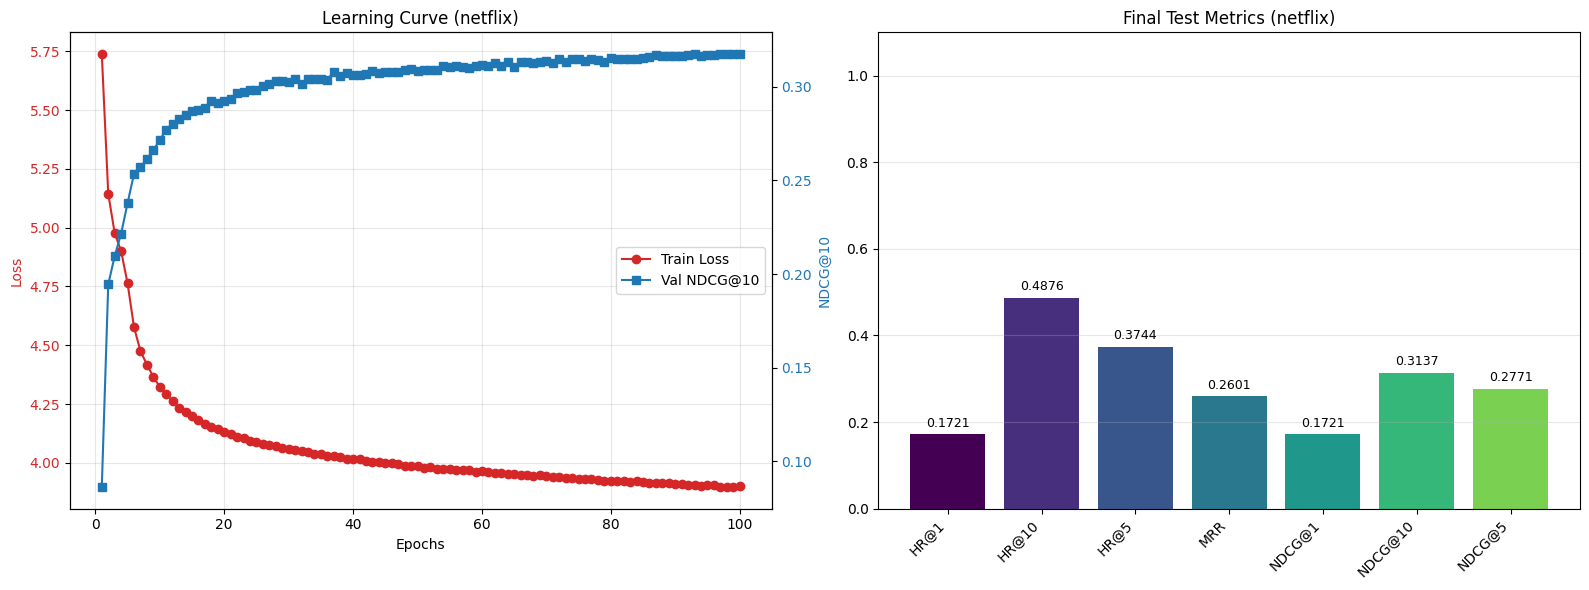

------------------------------
FINAL TEST RESULTS: netflix
------------------------------
MRR       : 0.2601
HR@1      : 0.1721
HR@5      : 0.3744
HR@10     : 0.4876
NDCG@1    : 0.1721
NDCG@5    : 0.2771
NDCG@10   : 0.3137
------------------------------


{'MRR': np.float64(0.2600902509402464),
 'HR@1': np.float64(0.17212033502877078),
 'HR@5': np.float64(0.37438577333873607),
 'HR@10': np.float64(0.48761857846841455),
 'NDCG@1': np.float64(0.17212033502877078),
 'NDCG@5': np.float64(0.27710115431464294),
 'NDCG@10': np.float64(0.31371741466981207)}

In [ ]:

run_training_pipeline("netflix", netflix_sequences, netflix_vocab)

In [ ]:
class Args:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.max_len = 100        # N
        self.hidden_units = 128   # d
        self.num_heads = 4       # h
        self.num_layers = 2       # L
        self.dropout_rate = 0.1
        self.mask_prob = 0.2      # rho
        self.batch_size = 128
        self.lr = 1e-5
        self.epochs = 50    #less epochs because it takes so much time to train
        self.mask_token = self.vocab_size + 1


Starting Run: ML-32M
Total Users: 200948
Train: 160758 | Val: 20095 | Test: 20095
Let's use 2 GPUs!
Training on cuda...
Epoch 1/50 | Train Loss: 8.5635 | LR: 0.000200
   Val NDCG@10: 0.0279 | HR@10: 0.0570
   -> Best model saved to bert4rec_ML-32M_best.pth
Epoch 2/50 | Train Loss: 6.5017 | LR: 0.000400
   Val NDCG@10: 0.1146 | HR@10: 0.2125
   -> Best model saved to bert4rec_ML-32M_best.pth
Epoch 3/50 | Train Loss: 5.5082 | LR: 0.000600
   Val NDCG@10: 0.1444 | HR@10: 0.2559
   -> Best model saved to bert4rec_ML-32M_best.pth
Epoch 4/50 | Train Loss: 5.0542 | LR: 0.000800
   Val NDCG@10: 0.1886 | HR@10: 0.3112
   -> Best model saved to bert4rec_ML-32M_best.pth
Epoch 5/50 | Train Loss: 4.7440 | LR: 0.001000
   Val NDCG@10: 0.2087 | HR@10: 0.3394
   -> Best model saved to bert4rec_ML-32M_best.pth
Epoch 6/50 | Train Loss: 4.3719 | LR: 0.000978
   Val NDCG@10: 0.2360 | HR@10: 0.3751
   -> Best model saved to bert4rec_ML-32M_best.pth
Epoch 7/50 | Train Loss: 4.1214 | LR: 0.000956
   Val NDC

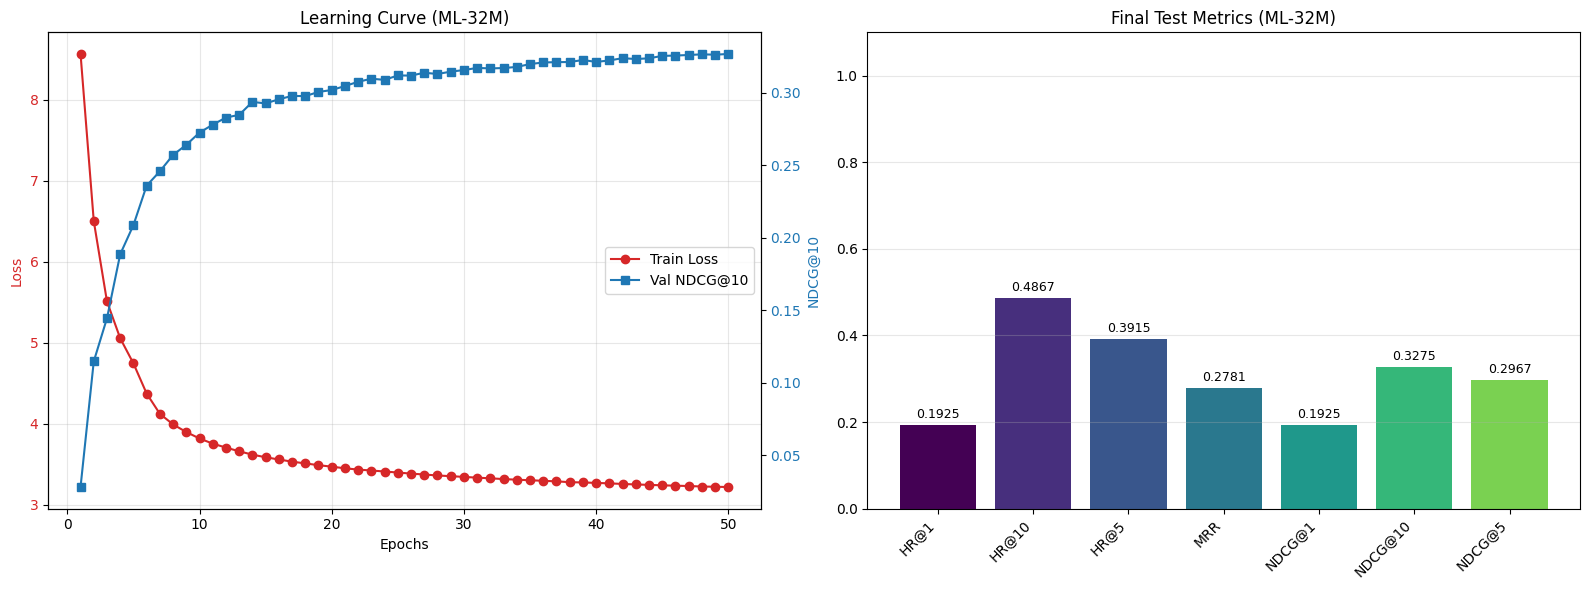

------------------------------
FINAL TEST RESULTS: ML-32M
------------------------------
MRR       : 0.2781
HR@1      : 0.1925
HR@5      : 0.3915
HR@10     : 0.4867
NDCG@1    : 0.1925
NDCG@5    : 0.2967
NDCG@10   : 0.3275
------------------------------


{'MRR': np.float64(0.2780661732907508),
 'HR@1': np.float64(0.19248551832642524),
 'HR@5': np.float64(0.39153989978656645),
 'HR@10': np.float64(0.486687913821761),
 'NDCG@1': np.float64(0.19248551832642524),
 'NDCG@5': np.float64(0.2967036206061673),
 'NDCG@10': np.float64(0.3275308206582525)}

In [ ]:
run_training_pipeline("ML-32M", ml_sequences, ml_vocab)

In [10]:
class Args:
    def __init__(self, vocab_size):
        self.vocab_size = vocab_size
        self.max_len = 100        # N
        self.hidden_units = 128   # d
        self.num_heads = 4       # h
        self.num_layers = 2       # L
        self.dropout_rate = 0.1
        self.mask_prob = 0.2      # rho
        self.batch_size = 64  #lowered to avoid gpu crash (I am training this on a 2xT4 which can't handle 128 as batch size)
        self.lr = 1e-5
        self.epochs = 50    #less epochs because it takes so much time to train
        self.mask_token = self.vocab_size + 1


Starting Run: ML-32M+NETFLIX
Total Users: 439960
Train: 351968 | Val: 43996 | Test: 43996
Training on cuda...
Epoch 1/50 | Train Loss: 7.5395 | LR: 0.000200
   Val NDCG@10: 0.1178 | HR@10: 0.2272
   -> Best model saved to bert4rec_ML-32M+netflix_best.pth
Epoch 2/50 | Train Loss: 5.6537 | LR: 0.000400
   Val NDCG@10: 0.1811 | HR@10: 0.3141
   -> Best model saved to bert4rec_ML-32M+netflix_best.pth
Epoch 3/50 | Train Loss: 4.8352 | LR: 0.000600
   Val NDCG@10: 0.2096 | HR@10: 0.3543
   -> Best model saved to bert4rec_ML-32M+netflix_best.pth
Epoch 4/50 | Train Loss: 4.4320 | LR: 0.000800
   Val NDCG@10: 0.2252 | HR@10: 0.3743
   -> Best model saved to bert4rec_ML-32M+netflix_best.pth
Epoch 5/50 | Train Loss: 4.2466 | LR: 0.001000
   Val NDCG@10: 0.2372 | HR@10: 0.3879
   -> Best model saved to bert4rec_ML-32M+netflix_best.pth
Epoch 6/50 | Train Loss: 4.1130 | LR: 0.000978
   Val NDCG@10: 0.2513 | HR@10: 0.4025
   -> Best model saved to bert4rec_ML-32M+netflix_best.pth
Epoch 7/50 | Train 

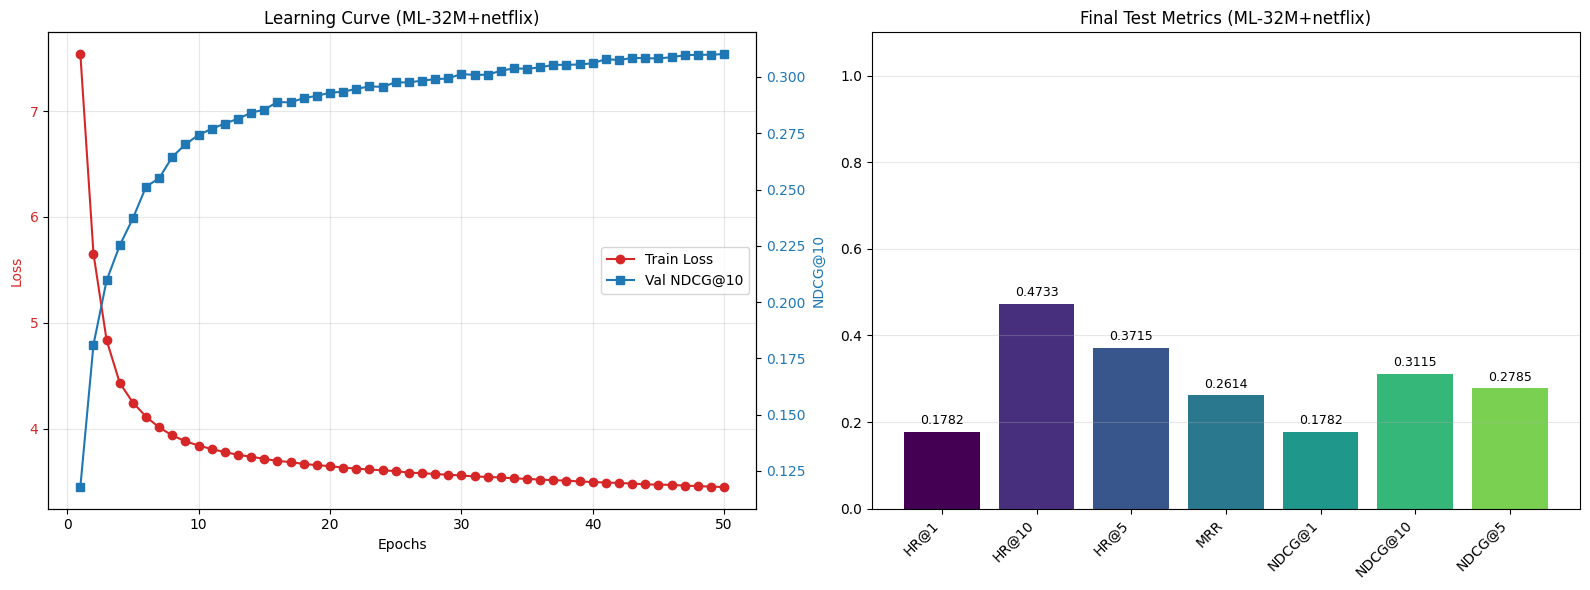

------------------------------
FINAL TEST RESULTS: ML-32M+netflix
------------------------------
MRR       : 0.2614
HR@1      : 0.1782
HR@5      : 0.3715
HR@10     : 0.4733
NDCG@1    : 0.1782
NDCG@5    : 0.2785
NDCG@10   : 0.3115
------------------------------


{'MRR': np.float64(0.26142130444519396),
 'HR@1': np.float64(0.17820156772815904),
 'HR@5': np.float64(0.37151552121653114),
 'HR@10': np.float64(0.4733343282931073),
 'NDCG@1': np.float64(0.17820156772815904),
 'NDCG@5': np.float64(0.2785491603318342),
 'NDCG@10': np.float64(0.3114528842703548)}

In [11]:
run_training_pipeline("ML-32M+netflix", combined_sequences, combined_vocab)